<a href="https://colab.research.google.com/github/DGuilherme/PMTese/blob/main/SimpleTransformerConvD1AllDatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
!pip install tensorflow scikit-learn

# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Compare all datasets

In [5]:
def run_predictive_maintenance(dataset_name, scaler_type='minmax', seq_length=50):
  # Load data
  column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]
  train_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_{dataset_name}.txt/train_{dataset_name}.txt', delim_whitespace=True, header=None)
  test_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_{dataset_name}.txt/test_{dataset_name}.txt', delim_whitespace=True, header=None)
  rul_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/RUL_{dataset_name}.txt/RUL_{dataset_name}.txt', delim_whitespace=True, header=None)


  train_data.columns = column_names
  test_data.columns = column_names
  rul_data.columns = ['RUL']
  rul_data['id'] = range(1, len(rul_data) + 1)

  # Generate RUL for training data
  cycle_max_train = train_data.groupby('id')['cycle'].max().reset_index().rename(columns={'cycle': 'cycle_max'})
  train_data = train_data.merge(cycle_max_train, on='id')
  train_data['RUL'] = train_data['cycle_max'] - train_data['cycle']
  train_data.drop(columns=['cycle_max'], inplace=True)

  # Generate RUL for test data
  cycle_max_test = test_data.groupby('id')['cycle'].max().reset_index().rename(columns={'cycle': 'cycle_max'})
  # Merge last observed cycle and ground-truth RUL on 'id'
  test_data = test_data.merge(cycle_max_test, on='id')
  test_data = test_data.merge(rul_data, on='id')

  test_data['RUL'] = test_data['RUL'] + test_data['cycle_max'] - test_data['cycle']
  test_data.drop(columns=['cycle_max'], inplace=True)

  # Select useful features (as suggested in papers)
  useful_sensor_cols = ['setting1', 'setting2', 'setting3'] + \
      [f'sensor{i}' for i in [2, 3, 4, 7, 8, 11, 12, 13, 14, 15, 17, 20, 21]]

  train_data = train_data[['id', 'cycle'] + useful_sensor_cols + ['RUL']]
  test_data = test_data[['id', 'cycle'] + useful_sensor_cols + ['RUL']]

  # Normalize sensor values
  scaler = MinMaxScaler()
  train_data[useful_sensor_cols] = scaler.fit_transform(train_data[useful_sensor_cols])
  test_data[useful_sensor_cols] = scaler.transform(test_data[useful_sensor_cols])

  # Windowing function
  def create_sequences(data, sequence_length=30):
      sequences = []
      labels = []
      engines = data['id'].unique()
      for engine_id in engines:
          engine_data = data[data['id'] == engine_id]
          feature_data = engine_data[useful_sensor_cols].values
          label_data = engine_data['RUL'].values
          for i in range(len(feature_data) - sequence_length + 1):
              sequences.append(feature_data[i:i+sequence_length])
              labels.append(label_data[i+sequence_length-1])
      return np.array(sequences), np.array(labels)

  # Create sequences
  X_train, y_train = create_sequences(train_data)
  X_test, y_test = create_sequences(test_data)

  print("Training set:", X_train.shape, y_train.shape)
  print("Testing set:", X_test.shape, y_test.shape)

  # Transformer Encoder
  def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
      # Attention block
      attn_output = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
      attn_output = layers.Dropout(dropout)(attn_output)
      x = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)  # Add & Norm

      # Feed Forward block
      ff_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
      ff_output = layers.Dropout(dropout)(ff_output)
      ff_output = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(ff_output)
      x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)  # Add & Norm

      return x

  # Build Model
  def build_model(input_shape, head_size=64, num_heads=4, ff_dim=128, num_transformer_blocks=2, mlp_units=[128], dropout=0.1, mlp_dropout=0.1, embedding_dim=64):
      inputs = keras.Input(shape=input_shape)
      x = inputs

      # https://www.tensorflow.org/tutorials/structured_data/time_series
      x = layers.Dense(embedding_dim)(inputs)

      for _ in range(num_transformer_blocks):
          x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

      x = layers.GlobalAveragePooling1D()(x)
      for units in mlp_units:
          x = layers.Dense(units, activation="relu")(x)
          x = layers.Dropout(mlp_dropout)(x)
      outputs = layers.Dense(1)(x)  # Predict RUL
      return keras.Model(inputs, outputs)

  # Compile Model
  input_shape = X_train.shape[1:]  # (window_size, num_features)
  model = build_model(input_shape)

  model.compile(
      loss="mse",
      optimizer=keras.optimizers.Adam(learning_rate=1e-4),
      metrics=["mae"]
  )

  model.summary()

  # Early stopping
  early_stopping = keras.callbacks.EarlyStopping(
  monitor="val_loss", patience=10, restore_best_weights=True)

  # Train
  history = model.fit(
      X_train, y_train,
      validation_split=0.2,
      epochs=100,
      batch_size=64,
      callbacks=[early_stopping]
  )

  # Plot loss curves
  plt.plot(history.history['loss'], label="Training Loss")
  plt.plot(history.history['val_loss'], label="Validation Loss")
  plt.legend()
  plt.show()

  # Evaluate
  #y_pred = model.predict(X_test).flatten()
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)

  print(f"Test RMSE: {rmse:.2f}")
  print(f"Test MAE: {mae:.2f}")

  # Optional: Plot true vs predicted RUL
  plt.figure(figsize=(10,5))
  plt.plot(y_test[:200], label="True RUL")
  plt.plot(y_pred[:200], label="Predicted RUL")
  plt.legend()
  plt.xlabel("Sample Index")
  plt.ylabel("RUL")
  plt.title("True vs Predicted RUL (First 200 Samples)")
  plt.show()

  return model, y_pred, rmse, mae


In [6]:
def compare_datasets(datasets, scaler_type='minmax', seq_length=50):
  results = []
  for dataset_name in datasets:
    model, predictions, rmse, mae = run_predictive_maintenance(dataset_name, scaler_type, seq_length)
    #rmse = np.sqrt(mse)  # Calculate RMSE
    results.append([dataset_name, rmse, mae])

  # Create a pandas DataFrame for the results
  results_df = pd.DataFrame(results, columns=['Dataset', 'RMSE', 'MAE'])
  return results_df


<ipython-input-5-d9903e4a4afc>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_{dataset_name}.txt/train_{dataset_name}.txt', delim_whitespace=True, header=None)
<ipython-input-5-d9903e4a4afc>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_{dataset_name}.txt/test_{dataset_name}.txt', delim_whitespace=True, header=None)
<ipython-input-5-d9903e4a4afc>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets

Training set: (17731, 30, 16) (17731,)
Testing set: (10196, 30, 16) (10196,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 16)    │     17,168 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 16)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 16)    │          0 │ input_layer[0][0… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 16)    │         32 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 128)   │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 128)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 16)    │      2,064 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 16)    │     17,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30, 16)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 30, 128)   │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 128)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 30, 16)    │      2,064 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 45,249 (176.75 KB)

 Trainable params: 45,249 (176.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - loss: 11549.1816 - mae: 90.1683 - val_loss: 15398.1465 - val_mae: 101.1775
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - loss: 10632.2627 - mae: 85.0632 - val_loss: 14249.0840 - val_mae: 95.8573
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - loss: 9627.0186 - mae: 79.3135 - val_loss: 12666.3799 - val_mae: 88.6260
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - loss: 8143.7930 - mae: 71.5939 - val_loss: 10858.3457 - val_mae: 80.5385
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - loss: 6732.3828 - mae: 64.1128 - val_loss: 9090.4258 - val_mae: 72.8479
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - loss: 5326.1343 - mae: 56.8143 - val_loss: 7366.3530 - val_mae: 62.0971
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - loss: 3983.9575 - mae: 45.0514 - val_loss: 5766.8008 - val_mae: 53.4001
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - loss: 2954.2251 - mae: 37.7151 - 

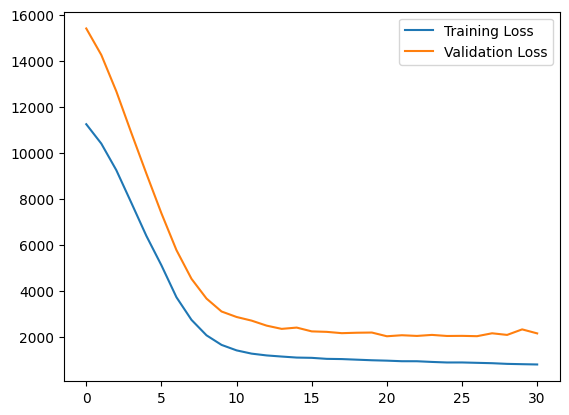

319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
Test RMSE: 41.37
Test MAE: 31.08


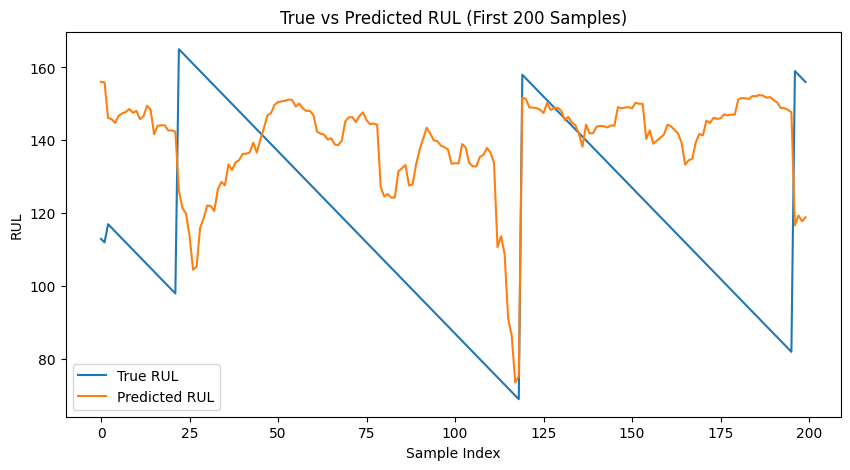

<ipython-input-5-d9903e4a4afc>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_{dataset_name}.txt/train_{dataset_name}.txt', delim_whitespace=True, header=None)
<ipython-input-5-d9903e4a4afc>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_{dataset_name}.txt/test_{dataset_name}.txt', delim_whitespace=True, header=None)
<ipython-input-5-d9903e4a4afc>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets

Training set: (46219, 30, 16) (46219,)
Testing set: (26505, 30, 16) (26505,)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 16)    │     17,168 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 30, 16)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 30, 16)    │          0 │ input_layer_1[0]… │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 30, 128)   │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 30, 128)   │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 30, 16)    │      2,064 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 16)    │     17,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 30, 16)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 30, 128)   │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 30, 128)   │          0 │ conv1d_6[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 30, 16)    │      2,064 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_7[0][0]     

 Total params: 45,249 (176.75 KB)

 Trainable params: 45,249 (176.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 66s 104ms/step - loss: 12158.9629 - mae: 91.1973 - val_loss: 10048.4121 - val_mae: 80.1877
Epoch 2/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 58s 100ms/step - loss: 9320.2939 - mae: 76.5045 - val_loss: 6461.0063 - val_mae: 61.7795
Epoch 3/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - loss: 5908.0752 - mae: 59.2715 - val_loss: 4219.9468 - val_mae: 51.4013
Epoch 4/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - loss: 4148.4521 - mae: 51.3427 - val_loss: 3836.8286 - val_mae: 50.5276
Epoch 5/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 83s 98ms/step - loss: 3916.0830 - mae: 50.7453 - val_loss: 3829.2500 - val_mae: 50.7894
Epoch 6/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 59s 103ms/step - loss: 3908.1025 - mae: 50.9301 - val_loss: 3828.6919 - val_mae: 50.7853
Epoch 7/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 81s 101ms/step - loss: 3865.8223 - mae: 50.2783 - val_loss: 2130.0652 - val_mae: 34.6299
Epoch 8/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 58s 100ms/step - loss: 2135.1311 - mae: 33.7442 - 

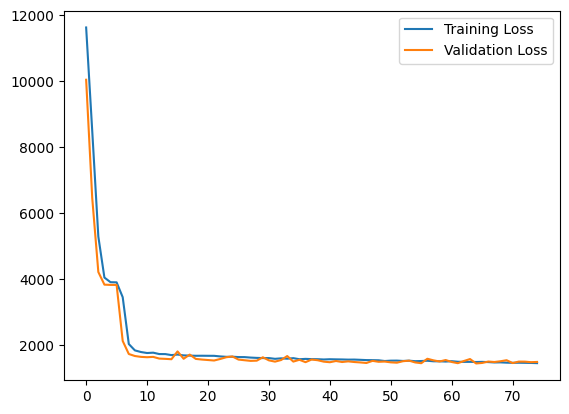

829/829 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step
Test RMSE: 47.07
Test MAE: 35.96


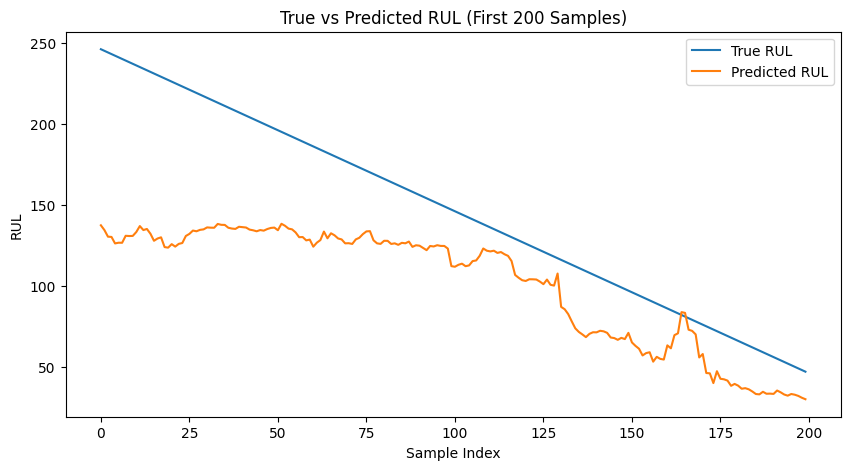

<ipython-input-5-d9903e4a4afc>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_{dataset_name}.txt/train_{dataset_name}.txt', delim_whitespace=True, header=None)
<ipython-input-5-d9903e4a4afc>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_{dataset_name}.txt/test_{dataset_name}.txt', delim_whitespace=True, header=None)
<ipython-input-5-d9903e4a4afc>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets

Training set: (21820, 30, 16) (21820,)
Testing set: (13696, 30, 16) (13696,)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 16)    │     17,168 │ input_layer_2[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 30, 16)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 30, 16)    │          0 │ input_layer_2[0]… │
│                     │                   │            │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 30, 128)   │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 30, 128)   │          0 │ conv1d_8[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 30, 16)    │      2,064 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 16)    │     17,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 30, 16)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 30, 128)   │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 30, 128)   │          0 │ conv1d_10[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 30, 16)    │      2,064 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_11[0][0] 

 Total params: 45,249 (176.75 KB)

 Trainable params: 45,249 (176.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - loss: 23639.3906 - mae: 122.6303 - val_loss: 23946.7734 - val_mae: 122.1975
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 39s 107ms/step - loss: 22297.0996 - mae: 117.4893 - val_loss: 21917.1484 - val_mae: 114.4854
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - loss: 19905.0430 - mae: 107.5813 - val_loss: 19112.8633 - val_mae: 104.0548
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - loss: 17323.4883 - mae: 97.7706 - val_loss: 16031.9121 - val_mae: 93.0279
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 14684.5049 - mae: 87.6465 - val_loss: 13228.5557 - val_mae: 83.6752
Epoch 6/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - loss: 11708.3486 - mae: 77.5068 - val_loss: 11122.0098 - val_mae: 77.5604
Epoch 7/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 10025.1875 - mae: 72.7872 - val_loss: 8893.0674 - val_mae: 64.0411
Epoch 8/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 7673.53

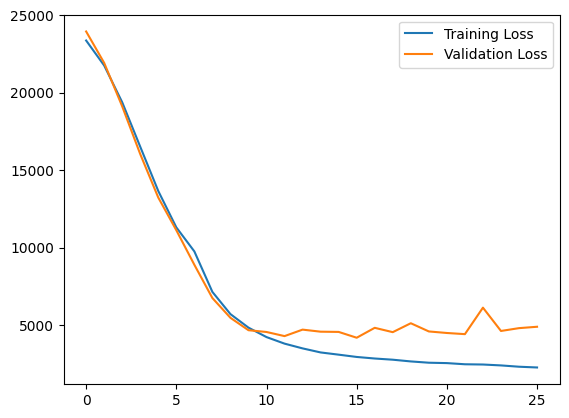

428/428 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step
Test RMSE: 63.79
Test MAE: 46.39


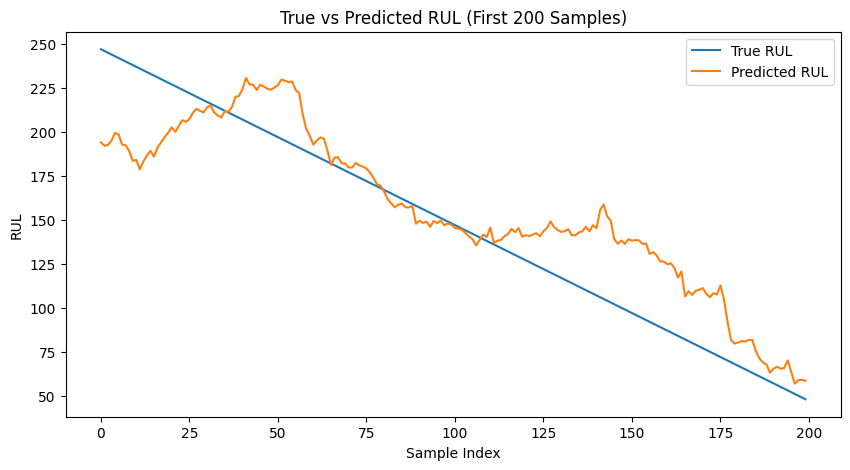

<ipython-input-5-d9903e4a4afc>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_{dataset_name}.txt/train_{dataset_name}.txt', delim_whitespace=True, header=None)
<ipython-input-5-d9903e4a4afc>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_{dataset_name}.txt/test_{dataset_name}.txt', delim_whitespace=True, header=None)
<ipython-input-5-d9903e4a4afc>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets

Training set: (54028, 30, 16) (54028,)
Testing set: (34081, 30, 16) (34081,)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 30, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 16)    │     17,168 │ input_layer_3[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 30, 16)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 30, 16)    │          0 │ input_layer_3[0]… │
│                     │                   │            │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 30, 128)   │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 30, 128)   │          0 │ conv1d_12[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 30, 16)    │      2,064 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 16)    │     17,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 30, 16)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 16)    │         32 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 30, 128)   │      2,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 30, 128)   │          0 │ conv1d_14[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 30, 16)    │      2,064 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 30, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_15[0][0] 

 Total params: 45,249 (176.75 KB)

 Trainable params: 45,249 (176.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
676/676 ━━━━━━━━━━━━━━━━━━━━ 84s 115ms/step - loss: 20854.1426 - mae: 117.1502 - val_loss: 15322.7275 - val_mae: 97.7983
Epoch 2/100
676/676 ━━━━━━━━━━━━━━━━━━━━ 73s 107ms/step - loss: 15663.9053 - mae: 96.2231 - val_loss: 8902.5352 - val_mae: 71.8416
Epoch 3/100
676/676 ━━━━━━━━━━━━━━━━━━━━ 71s 106ms/step - loss: 9496.9502 - mae: 73.3482 - val_loss: 6272.7646 - val_mae: 63.5225
Epoch 4/100
676/676 ━━━━━━━━━━━━━━━━━━━━ 84s 109ms/step - loss: 7303.5234 - mae: 67.2794 - val_loss: 6168.8960 - val_mae: 64.3842
Epoch 5/100
676/676 ━━━━━━━━━━━━━━━━━━━━ 80s 107ms/step - loss: 7169.9399 - mae: 67.7451 - val_loss: 6104.6396 - val_mae: 63.6011
Epoch 6/100
676/676 ━━━━━━━━━━━━━━━━━━━━ 82s 107ms/step - loss: 5634.9907 - mae: 55.9127 - val_loss: 3080.3296 - val_mae: 41.7145
Epoch 7/100
676/676 ━━━━━━━━━━━━━━━━━━━━ 81s 106ms/step - loss: 3750.3079 - mae: 44.3436 - val_loss: 2966.5674 - val_mae: 40.7649
Epoch 8/100
676/676 ━━━━━━━━━━━━━━━━━━━━ 83s 107ms/step - loss: 3600.3064 - mae: 43.50

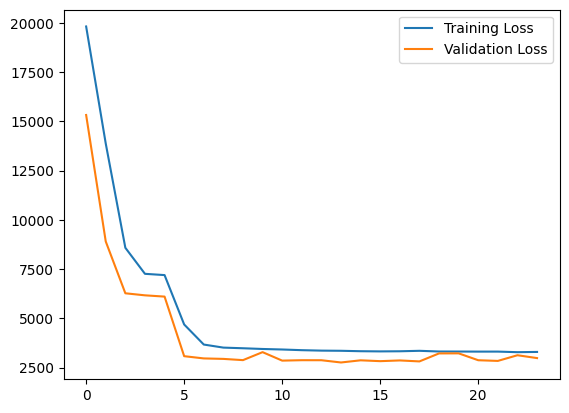

1066/1066 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step
Test RMSE: 74.23
Test MAE: 55.02


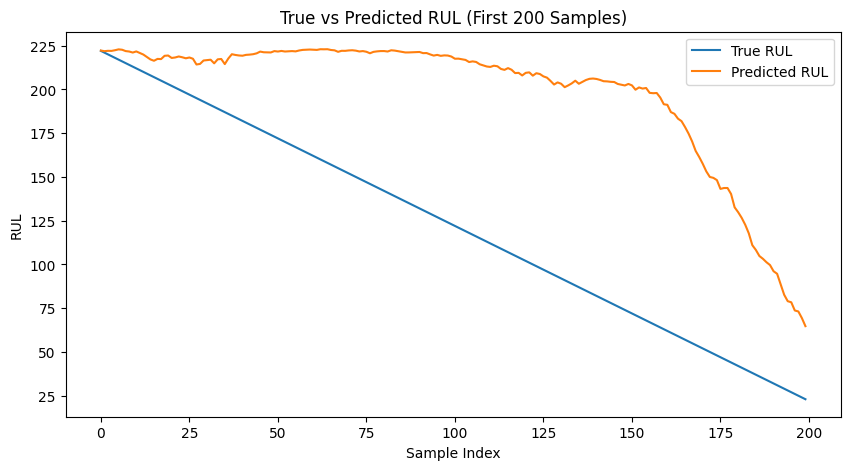

,Dataset,RMSE,MAE
0,FD001,41.369533,31.081490
1,FD002,47.069049,35.963699
2,FD003,63.790218,46.393681
3,FD004,74.234363,55.023716


In [7]:
# Define the list of datasets
datasets = ['FD001', 'FD002', 'FD003', 'FD004']  # Add your dataset names here

# Run the comparison
results_df = compare_datasets(datasets, scaler_type='minmax', seq_length=60)

# Display the results table
display(results_df)